In [14]:
import numpy as np
from sklearn.datasets import make_classification
from scipy.stats import chi2, norm
import matplotlib.pyplot as plt
from math import atan, exp, pi, log

In [15]:
A=0.05
B=0.6
def f(x_1,x_2, a=A, b=B):
  '''effectue une transformation affine en échelle log (de l'argument maximal) tq :
  f(a) = arctan(-5) (1ère l'inflexion)
  f(b) = arctan(5) (2ème l'inflexion)
  '''
  x = np.max([x_1, x_2])
  cd= 10/(log(b)-log(a))
  oo= -5 - log(a)*cd
  if x==0:
    return 0

  return(atan(log(x)*cd + oo)/pi+0.5)



def covariance_empirique(X):
  """
  Calculates the empirical covariance matrix of a dataset.

  Args:
    X: A NumPy array representing the dataset, where each row is a sample
       and each column is a feature.

  Returns:
    A NumPy array representing the empirical covariance matrix.
  """
  n = X.shape[0]  # Number of samples
  d = X.shape[1]  # Number of features
  # Center the data (subtract the mean of each feature)
  X_centered = X - np.mean(X, axis=0)
  # Calculate the covariance matrix
  covariance_matrix = np.dot(X_centered.T, X_centered) / (n - 1)
  return covariance_matrix




def mesure_quantiles(X, y, alpha=0.99999, mu_a=0, Sigma_a=0, mu_b=0, Sigma_b=0, parametres_forcees = False, combinaison  = f) : #on se donne un quantile, on regarde quelle proportion d'éléments de la classe 2 sont dans la classe 1, vice versa et on en dédeuit un truc
  #print('feurfeurfeurfeurfeur')
  """
  Donne une valeur de distance (entre 0 & 1) entre deux gaussiennes.
  Considère les ellipses définies par un quantile, et plus exactement la proportion des points de l'autre gaussienne qui sont dans l'ellipse.
  le résultat final est une fonction de ces deux proportions

  Args:
   X : coordonnées des points dans l'espace (réels)
   Y : vecteur d'appartenance à une classe (tout types, toutes valeurs tant qu'il y en a exactement 1 unique type et deux différentes valeurs)
   alpha : quantile choisi (entre 0 et 1) (par défaut, 0.99999)
   mu_a : moyenne de la gaussienne A (par défaut, moyenne empirique)
   Sigma_a : covariance de la gaussienne A (par défaut, matrice de covariance empirique)
   mu_b : moyenne de la gaussienne B (par défaut, moyenne empirique)
   Sigma_b : covariance de la gaussienne B (par défaut, matrice de covariance empirique
   paramètres_forcés : si les moyennes / variances sont connues, mettre ce paramètre à True, et choisir des valeurs pour mu_a, mu_b, Sigma_a, Sig (booléen)(par défaut: False)
   combinaison : prends deux proportions (des points dans les ellipses), et renvoie un score. Par défaut : f

  """
  a,b = np.unique(y)[0], np.unique(y)[1]
  points_classe_a = X[y == a]
  points_classe_b = X[y == b]
  if parametres_forcees :
    m_a,m_b = mu_a, mu_b
    S_a,S_b = Sigma_a, Sigma_b

  else :#si l'utilisateur n'a pas entré de valeurs pour mu_a etc, on les calcule à la main
    m_a,m_b = np.mean(points_classe_a, axis= 0), np.mean(points_classe_b, axis= 0)
    S_a = covariance_empirique(points_classe_a)
    S_b = covariance_empirique(points_classe_b)

  dimension = len(m_a)  # Dimension de la gaussienne
  quantile = np.sqrt(chi2.ppf(alpha, df=dimension))

  #on compte la proportion de points de A dans le quantile alpha de B
  cpt_a =0
  S_inv_b= np.linalg.inv(S_b)
  for x_a in points_classe_a:
    delta_x_a = x_a - m_b
    dist_mahalanobis_b = np.sqrt(delta_x_a.T @ S_inv_b@ delta_x_a)
    if dist_mahalanobis_b < quantile:
      est_dans_quantile = True
    else:
      est_dans_quantile = False
    if est_dans_quantile:
      cpt_a += 1
  prop_a = cpt_a / len(points_classe_a)
  print('feur_a', prop_a)

  #idem pour b
  cpt_b =0

  S_inv_a= np.linalg.inv(S_a)
  for x_b in points_classe_b:
    delta_x_b = x_b - m_a
    dist_mahalanobis_a = np.sqrt(delta_x_b.T @ S_inv_b @ delta_x_b)
    if dist_mahalanobis_a < quantile:
      est_dans_quantile = True
    else:
      est_dans_quantile = False
    if est_dans_quantile:
      cpt_b += 1
  prop_b = cpt_b/ len(points_classe_b)
  print('feur_b', prop_b)
  return(f(prop_a, prop_b))




In [16]:
#pour faire des tests de la mesure sur plusieurs paires de gaussiennes

def imprimer_ellipses (moyenne_1, moyenne_2, covariance_1, covariance_2, quantile=0.99999):
  donnees_1 = np.random.multivariate_normal(moyenne_1, covariance_1, size=1000)
  Y_1 = np.zeros(1000)
  donnees_2 = np.random.multivariate_normal(moyenne_2, covariance_2, size=1000)
  Y_2 = np.ones(1000)
  X= np.concatenate((donnees_1, donnees_2), axis=0)
  Y= np.concatenate((Y_1, Y_2), axis=0)

  # affichage du nuage de points
  plt.scatter(X[:,0], X[:,1], c=Y)

  #calcul des valeurs des axes pour l'ellipse

  #ellipse 1
  dimension_1 = len(moyenne_1)
  quantile_1 = np.sqrt(chi2.ppf(quant, df=dimension_1))
  valeurs_propres_1, vecteurs_propres_1 = np.linalg.eigh(covariance_1)
  quantile_ajuste_1 = quantile_1 * np.sqrt(valeurs_propres_1)

  centre_1  = moyenne_1
  axe1_1 = vecteurs_propres_1[:,0] * quantile_ajuste_1[0]
  axe2_1 = vecteurs_propres_1[:,1] * quantile_ajuste_1[1]
  theta = np.linspace(0, 2*np.pi, 300)
  x_1 = centre_1[0] + axe1_1[0]*np.cos(theta) + axe2_1[0]*np.sin(theta)
  y_1 = centre_1[1] + axe1_1[1]*np.cos(theta) + axe2_1[1]*np.sin(theta)
  plt.plot(x_1,y_1, 'r')

  #ellipse 2
  dimension_2 = len(moyenne_2)
  quantile_2 = np.sqrt(chi2.ppf(quant, df=dimension_2))
  valeurs_propres_2, vecteurs_propres_2 = np.linalg.eigh(covariance_2)
  quantile_ajuste_2 = quantile_2 * np.sqrt(valeurs_propres_2)

  centre_2  = moyenne_2
  axe1_2 = vecteurs_propres_2[:,0] * quantile_ajuste_2[0]
  axe2_2 = vecteurs_propres_2[:,1] * quantile_ajuste_2[1]
  theta = np.linspace(0, 2*np.pi, 300)
  x_2 = centre_2[0] + axe1_2[0]*np.cos(theta) + axe2_2[0]*np.sin(theta)
  y_2 = centre_2[1] + axe1_2[1]*np.cos(theta) + axe2_2[1]*np.sin(theta)
  plt.plot(x_2,y_2, 'b')

  plt.show()
  print(mesure_quantiles(X, Y, alpha=quant))



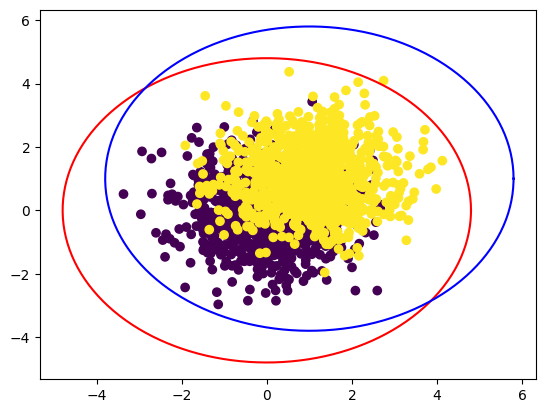

feur_a 1.0
feur_b 0.999
0.9551847028649821


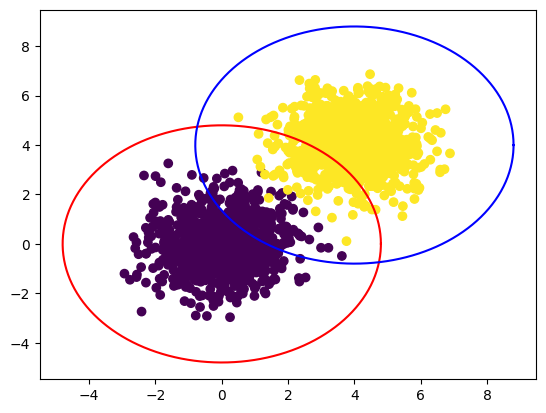

feur_a 0.181
feur_b 0.181
0.555810315319747


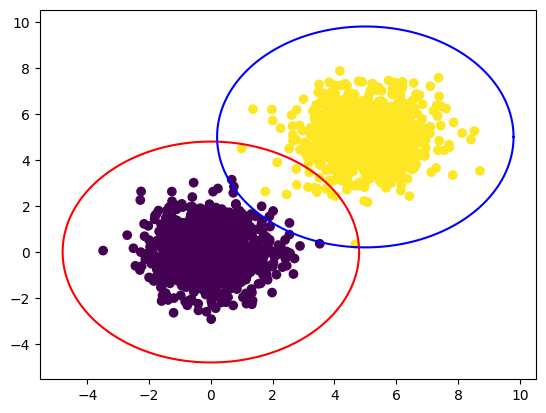

feur_a 0.008
feur_b 0.018
0.03479597298725012


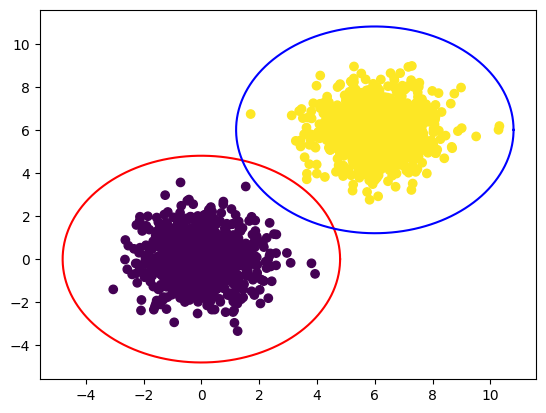

feur_a 0.0
feur_b 0.0
0


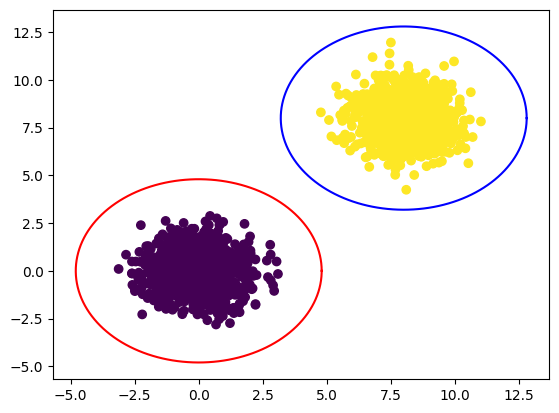

feur_a 0.0
feur_b 0.0
0


In [17]:
moyennes_1 = [[0,0], [0,0], [0,0],[0,0], [0,0]]
moyennes_2 = [[1,1], [4,4],[5,5], [6,6], [8,8]]
covariances_1 = [[[1,0],[0,1]]]*5
covariances_2 = [[[1,0],[0,1]]]*5
quant=0.99999
for i in range(len(moyennes_1)):
  imprimer_ellipses(moyennes_1[i], moyennes_2[i], covariances_1[i], covariances_2[i])

feur_b 0.90047


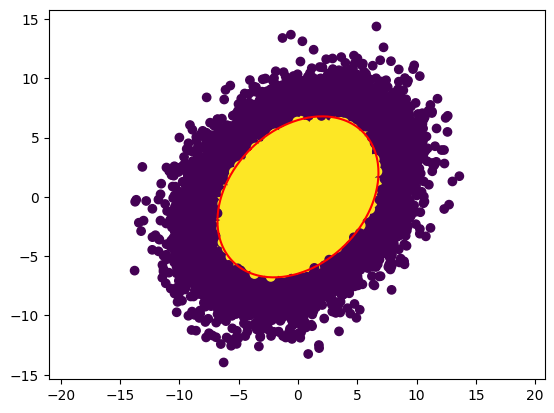

In [18]:
#vérifie l'utilisation de la distance de mahalanobis



moyenne = [0,0]
covariance = [[10,3],[3,10]]
alpha = 0.9
donnees = np.random.multivariate_normal(moyenne, covariance, size=100000)

import matplotlib.pyplot as plt

dimension = len(moyenne)
quantile = np.sqrt(chi2.ppf(alpha, df=dimension))
valeurs_propres, vecteurs_propres = np.linalg.eigh(covariance)
quantile_ajuste = quantile * np.sqrt(valeurs_propres)

centre  = moyenne
axe1 = vecteurs_propres[:,0] * quantile_ajuste[0]
axe2 = vecteurs_propres[:,1] * quantile_ajuste[1]
theta = np.linspace(0, 2*np.pi, 300)
x = centre[0] + axe1[0]*np.cos(theta) + axe2[0]*np.sin(theta)
y = centre[1] + axe1[1]*np.cos(theta) + axe2[1]*np.sin(theta)


cpt_b =0
Y_couleur= np.zeros(len(donnees))
S_inv = np.linalg.inv(covariance)
for j in range(len(donnees)):
  x_b = donnees[j]
  delta_x = x_b - centre
  dist_mahalanobis = np.sqrt(delta_x.T @ S_inv @ delta_x)
  if dist_mahalanobis < quantile:
    est_dans_quantile = True
  else:
    est_dans_quantile = False
  if est_dans_quantile:
    cpt_b += 1
    Y_couleur[j] = 1
prop_b = cpt_b/ len(donnees)
print('feur_b', prop_b)

plt.scatter(donnees[:,0], donnees[:,1], c=Y_couleur)
plt.plot(x, y, 'r')
plt.axis('equal')  # Pour avoir des axes isotropes
plt.show()

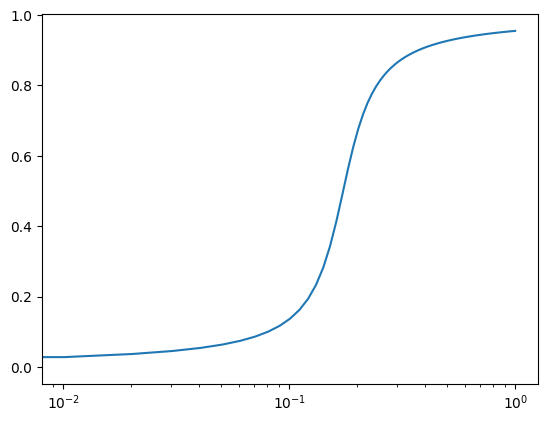

In [19]:
#plot f
X= np.linspace(0,1,100)
Y= [f(x,x) for x in X]
plt.plot(X,Y )
plt.xscale('log')
plt.show()